In [1]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

import rasterio
import keras
from keras import layers

from umap.parametric_umap import ParametricUMAP

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
#pathSatellite = folderName + "Landsat-8.tif"
#pathNight = folderName + "Night VIIRS_1.tif"
pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, validThreshold=1, area=aoi)

trainMask = dataRadiance>25
testMask = dataRadiance<2
lightCoords = dataCoords[trainMask]
darkCoords = dataCoords[testMask]

print('Tiles:',dataCoords.shape[0])
print('Light Tile:',lightCoords.shape[0])


Tiles: 137868
Light Tile: 894


In [7]:
# Fetch images
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.getEachImgFromCoord(f, dataCoords[trainMask], True)
trainData = utils.formatData(trainData, res=64, toFloat=True)
print(trainData.shape)

with rasterio.open(pathSatellite) as f:
  testData, _ = utils.getEachImgFromCoord(f, dataCoords[testMask][:1000], True)
testData = utils.formatData(testData, res=64, toFloat=True)
print(testData.shape)

(894, 64, 64, 3)
(1000, 64, 64, 3)


# UMAP

In [8]:
trainDataTot = np.concatenate((trainData, testData),axis=0)

In [9]:
trainDataTot.shape
trainDataFormated = tf.reshape(trainDataTot, [trainDataTot.shape[0], -1])
print('shape',trainDataTot.shape,trainDataFormated.shape)

shape (1894, 64, 64, 3) (1894, 12288)


In [11]:
input_shape=trainDataTot.shape[1:]
print(input_shape)

encoder = keras.Sequential([
  layers.Conv2D(16,(3,3), 2, padding='same', activation='relu', input_shape=input_shape),
  layers.Conv2D(16,(3,3), 2, padding='same', activation='relu'),
  #layers.Conv2D(16,(3,3), 2, padding='same', activation='relu'),

  layers.Flatten(),
  layers.Dense(units=2, name='encoder'),
])
decoder = keras.Sequential([
  layers.Dense(np.prod((32,32,16)), activation='relu', input_shape=(2,)),
  layers.Reshape(target_shape=(32,32,16)),
  #layers.UpSampling2D((2,2)),
  #layers.Conv2D(16,(3,3), padding='same', activation='relu'),
  layers.UpSampling2D((2,2)),
  layers.Conv2D(16,(3,3), padding='same', activation='relu'),
  layers.UpSampling2D((2,2)),

  layers.Conv2D(3, (3,3), padding='same', activation='sigmoid'),
])
lossFunction = keras.losses.MeanSquaredError() # l2

embedder = ParametricUMAP(
  encoder=encoder,
  #decoder=decoder,
  autoencoder_loss=True,
  #parametric_reconstruction_loss_fcn=lossFunction,
  dims=input_shape,
  parametric_reconstruction= True,
  parametric_embedding=False,
  #n_training_epochs = 1,
  loss_report_frequency=20,
  keras_fit_kwargs={
    "callbacks": [TqdmCallback(verbose=1)],
    "verbose": 0,
  },
  #reconstruction_validation=test,
  verbose=False,
)
t = 2000
#embedding = umap.UMAP(random_state=42).fit_transform(data_train[:t])
embedding = embedder.fit_transform(trainDataFormated)



(64, 64, 3)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

c:\Users\junodch\.conda\envs\BT-Junodch\lib\site-packages\umap\parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(
c:\Users\junodch\.conda\envs\BT-Junodch\lib\site-packages\umap\parametric_umap.py:173: UserWarning: Parametric decoding is not implemented with nonparametric             embedding. Turning off parametric decoding
  warn(


60/60 [==============================] - 1s 12ms/step


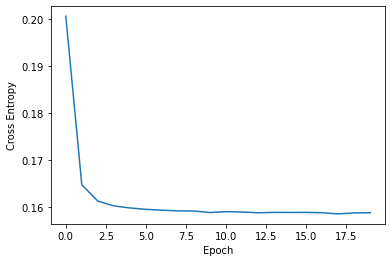

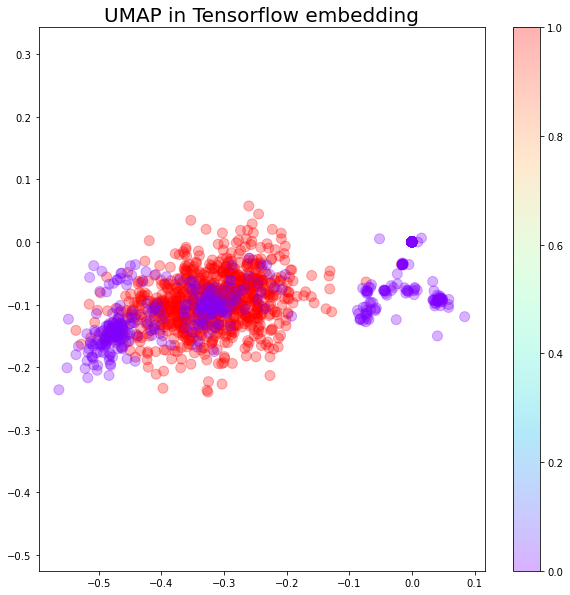

In [14]:
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')
embedding = encoder.predict(np.concatenate((trainData,testData), axis=0))
fig, ax2 = plt.subplots( figsize=(10, 10))
sc = ax2.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c= [1]*len(trainData) + [0]*len(testData),
    cmap='rainbow',
    s=100,
    alpha=0.3,
    rasterized=True,
)
ax2.axis('equal')
ax2.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax2)

In [ ]:
def displayAutoencoderUmapResults(autoencoder, dataInput, precision=0, isEmbedded=True):
  MAX_ON_ROW = 20
  total = dataInput.shape[0]
  nRow = (dataInput.shape[0] // MAX_ON_ROW) + 1
  nCol = MAX_ON_ROW if total > MAX_ON_ROW else total

  # Display original
  plt.figure(figsize=(30,nRow*2))
  for i in range(0, total):
    ax = plt.subplot(nRow, nCol, 1+i)
    plt.imshow(dataInput[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  print("Original data:",dataInput.shape)
  plt.show()

  # Display reconstruction
  if isEmbedded:
    decoded_imgs = autoencoder.inverse_transform(autoencoder.transform(dataInput))
  else:
    test = []
    for d in dataInput:
      test.append(tf.reshape(d, [-1]))
    decoded_imgs = autoencoder.inverse_transform(autoencoder.transform(test))
  plt.figure(figsize=(30,nRow*2))
  print("Output data:",decoded_imgs.shape)
  for i in range(0, decoded_imgs.shape[0]):
    ax = plt.subplot(nRow, nCol, 1+i)
    if isEmbedded:
      decoded_img = decoded_imgs[i]
    else:
      decoded_img = tf.reshape(decoded_imgs[i], [64,64,3])
    plt.imshow(decoded_img)
    score = lossFunction(dataInput[i], decoded_img)
    plt.title(np.round(score,precision))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
displayAutoencoderUmapResults(embedder, trainData, precision=5, isEmbedded=False)

In [ ]:
with rasterio.open(pathSatellite) as s:
  validation, metaValid = utils.getEachImgFromCoord(s, test[0:1] + test[1104:1123]+ test[4000:4010]+ test[10000:10010], True)
  #validation, metaValid = utils.getEachImgFromCoord(s, test[0:1] + test[1104:1123]+ test[2944:2964]+ test[4000:4020]+ test[5000:5020]+ test[10000:10020], True)

displayAutoencoderUmapResults(embedder, utils.formatDataForAutoencoder(validation,res=64), precision=5, isEmbedded=False)

In [ ]:
embedder.save('model/autoencoder_64_GEN8_V2')

In [ ]:
# Display area test
with rasterio.open(pathSatellite) as s:
  validationTest, metaValidTest = utils.getEachImgFromCoord(s, test[0:10] + test[368:378] + test[736:746] + test[1104:1114] + test[1472:1482], True)

utils.displayTiles(validationTest, metaValidTest)